<a href="https://colab.research.google.com/github/visist16/LGMVIP_Data-Science/blob/main/LGMVIP-DataScience-Task2%20/Stock_Market_Price_Prediction_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

from datetime import datetime

In [2]:

# List of tech stocks and their symbols
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up start and end dates
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)


In [3]:
# Download stock data and store in separate DataFrames
company_list = [yf.download(stock, start, end) for stock in tech_list]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:

# Add company name to each DataFrame and concatenate them
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
df = pd.concat(company_list, axis=0)

In [5]:
# Basic descriptive statistics
print(df.describe())
print(df.info())

              Open         High          Low        Close    Adj Close  \
count  1008.000000  1008.000000  1008.000000  1008.000000  1008.000000   
mean    163.724218   165.741686   161.888500   163.854132   163.390106   
std      73.536964    74.170403    72.939535    73.562223    73.119177   
min      82.800003    83.480003    81.430000    81.820000    81.820000   
25%     104.171247   105.910000   103.254997   104.412498   104.412498   
50%     134.529999   136.040001   133.235001   134.814995   134.657791   
75%     201.567505   203.774998   199.817497   200.899998   200.188797   
max     361.750000   366.779999   352.440002   359.489990   358.730469   

             Volume  
count  1.008000e+03  
mean   4.797947e+07  
std    2.791553e+07  
min    5.466162e+06  
25%    2.512328e+07  
50%    4.351010e+07  
75%    6.298142e+07  
max    2.231334e+08  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2022-08-31 to 2023-08-31
Data columns (total 7 columns):
 #   Column

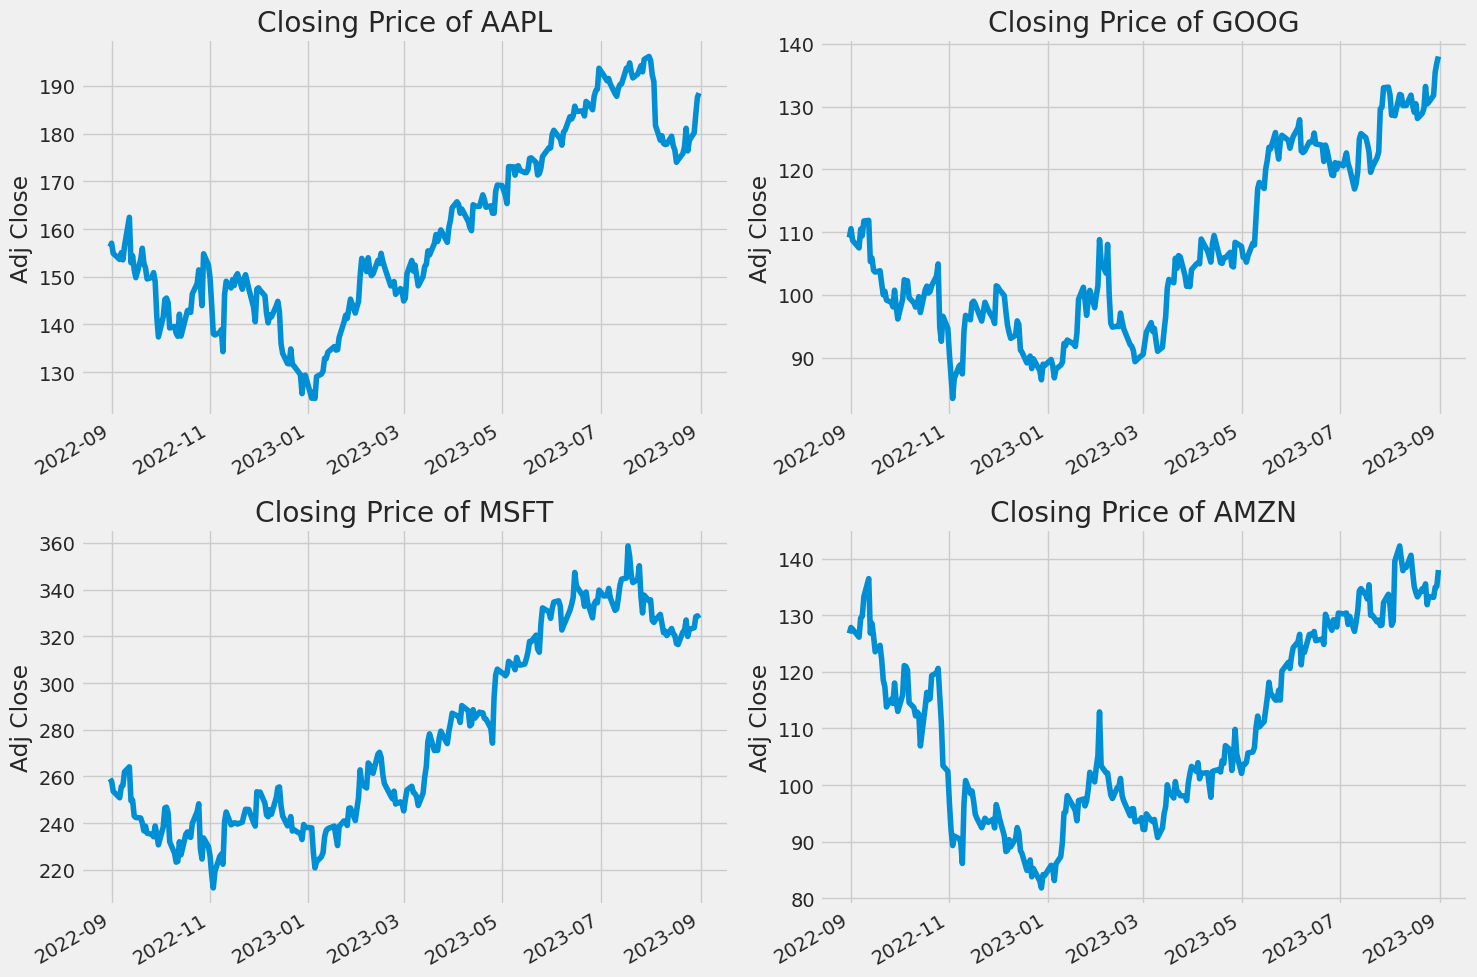

In [6]:
# Closing price visualization
plt.figure(figsize=(15, 10))
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")
plt.tight_layout()

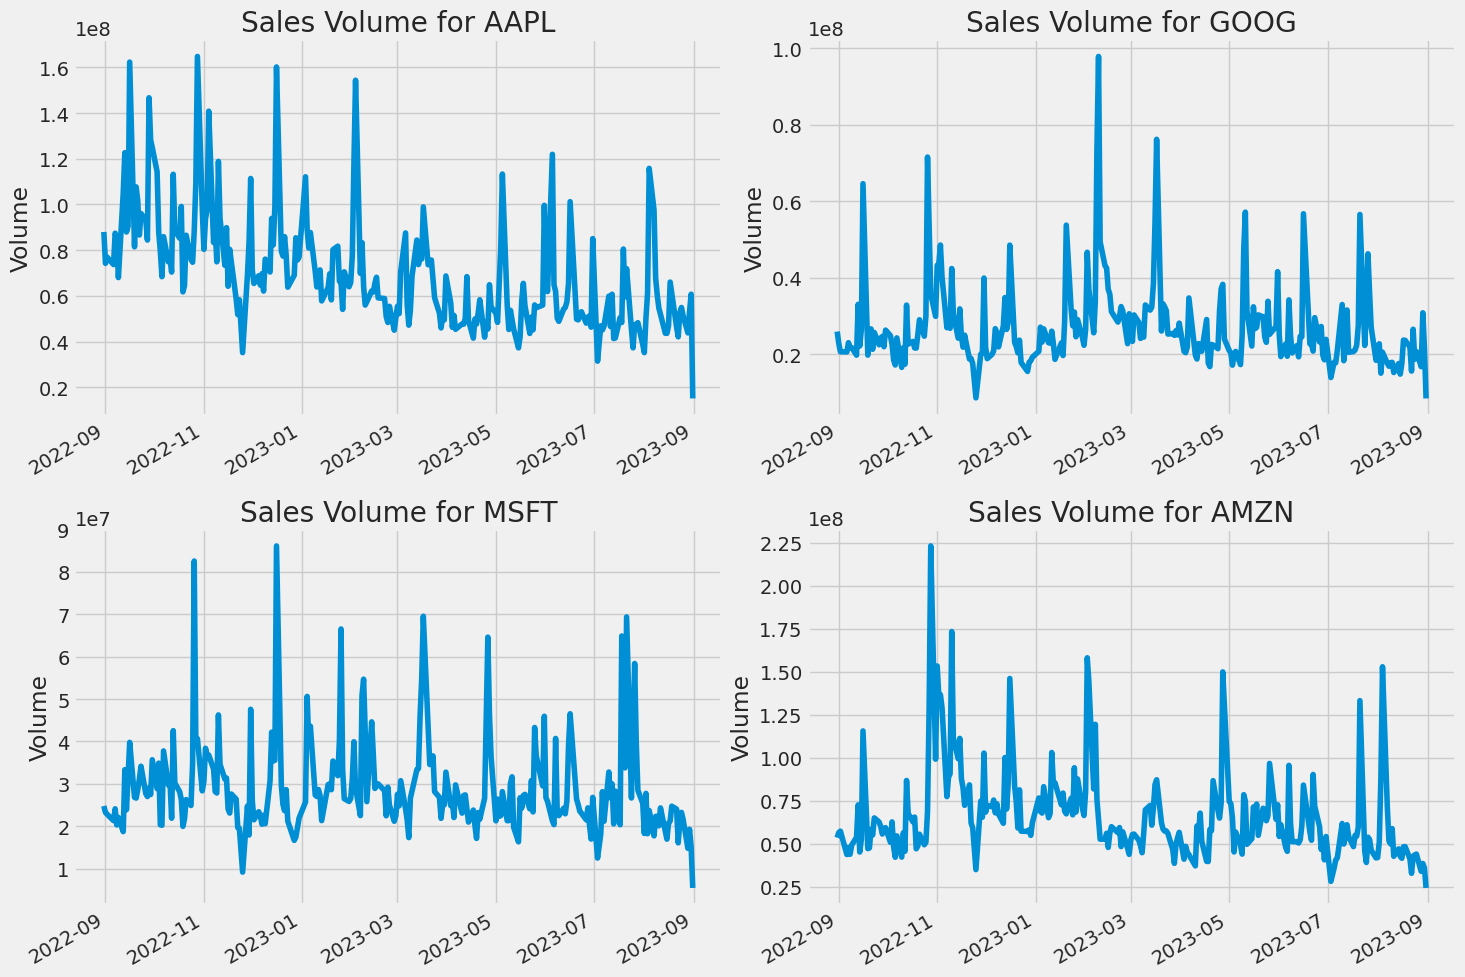

In [7]:
# Volume of sales visualization
plt.figure(figsize=(15, 10))
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
plt.tight_layout()

In [8]:
# Moving averages
ma_day = [10, 20, 50]
for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()

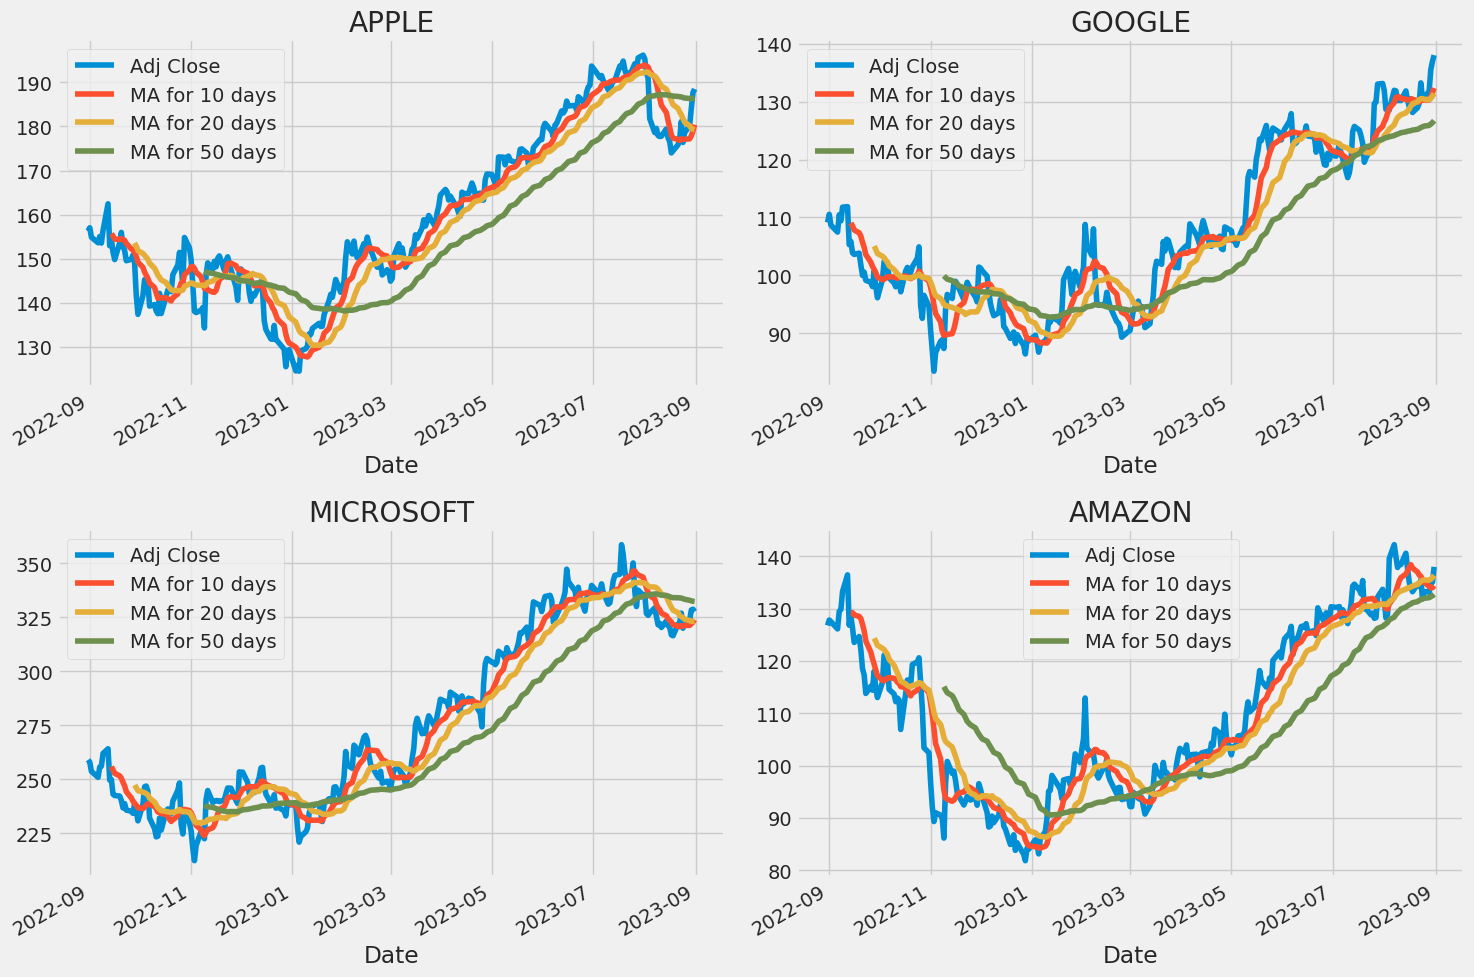

In [9]:

# Plotting moving averages
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
for i, company in enumerate(company_list, 1):
    axes_idx = (i - 1) // 2, (i - 1) % 2
    company[['Adj Close', f'MA for 10 days', f'MA for 20 days', f'MA for 50 days']].plot(ax=axes[axes_idx])
    axes[axes_idx].set_title(f'{company_name[i - 1]}')
fig.tight_layout()

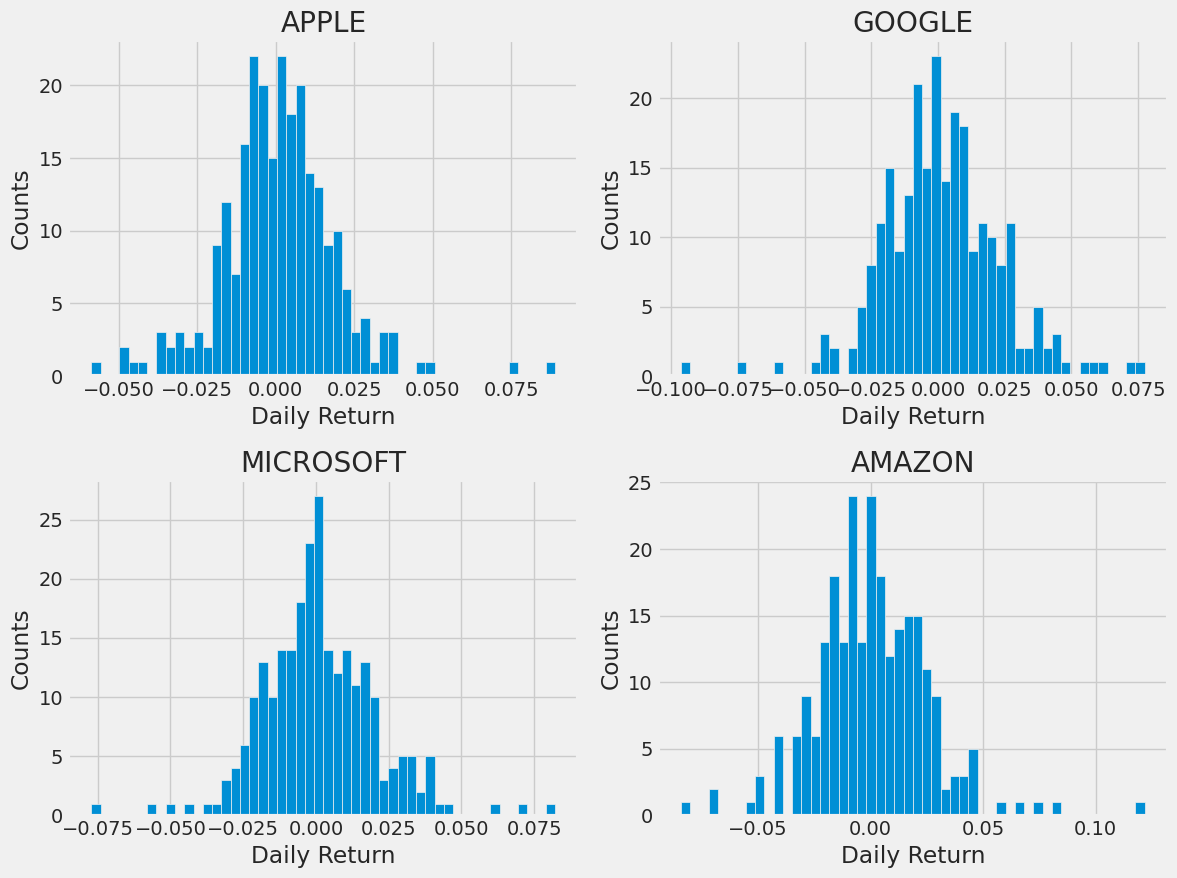

In [10]:
# Daily returns and visualization
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

plt.figure(figsize=(12, 9))
for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
plt.tight_layout()

In [15]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Stock price prediction using LSTM
data = df.filter(['Close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(dataset) * 0.95))
train_data = scaled_data[0:int(training_data_len), :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)


898/898 [==============================] - 47s 49ms/step - loss: 0.0068


In [16]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f'Root Mean Squared Error: {rmse}')

2/2 [==============================] - 1s 24ms/step
Root Mean Squared Error: 4.748605930254739


In [17]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

<ipython-input-17-8f78faa8f9ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


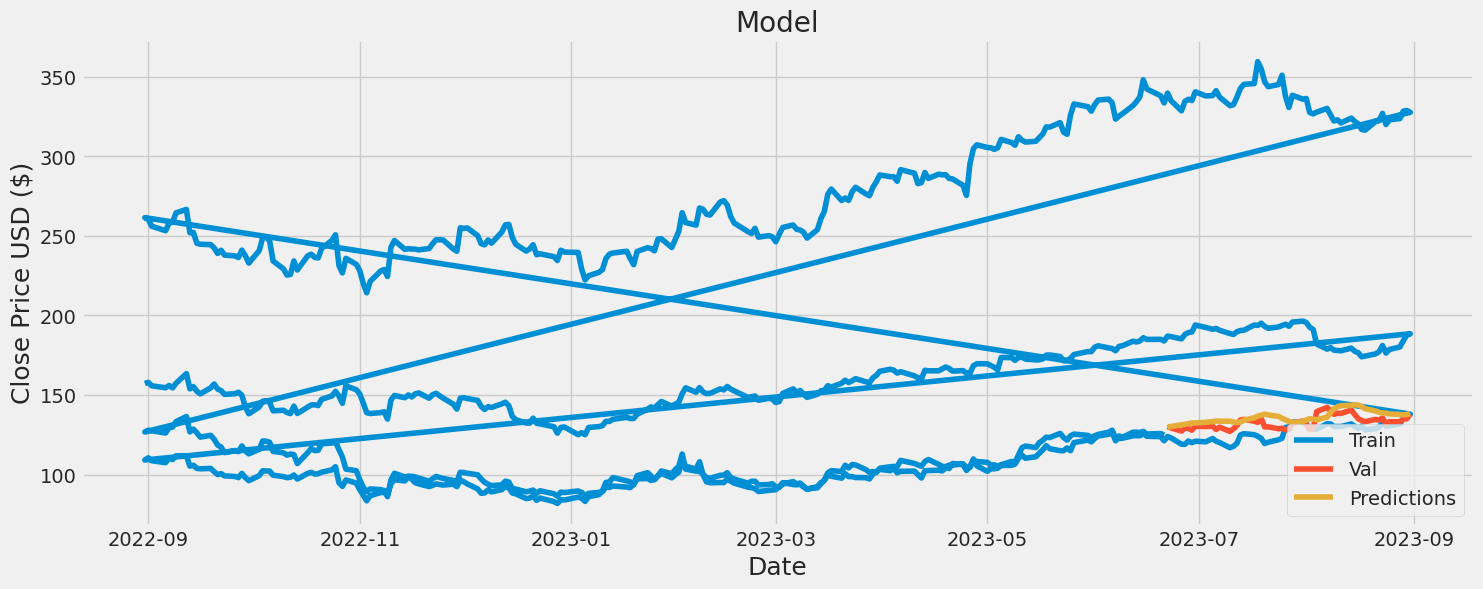

In [18]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()